In this notebook, we'll introduce a simple GAN to learn a probability distribution.

In this case, the base distribution is going to be a normal distribution centered at 0 plus

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams["figure.figsize"]=(12,6)
import keras.backend as K

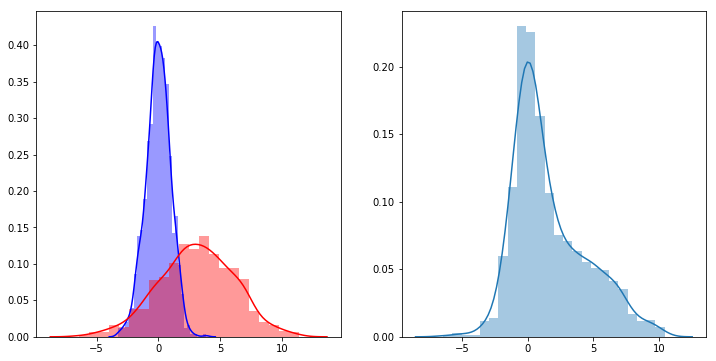

In [72]:
a=np.random.normal(loc=0,scale=1,size=1000)
b=np.random.normal(loc=3,scale=3,size=1000)
ran=np.random.uniform(size=1000)
c=np.where(ran<0.5,a,b)

plt.subplot(1,2,1)
sns.distplot(a,color="b")
sns.distplot(b,color="r")
plt.subplot(1,2,2)
sns.distplot(c)

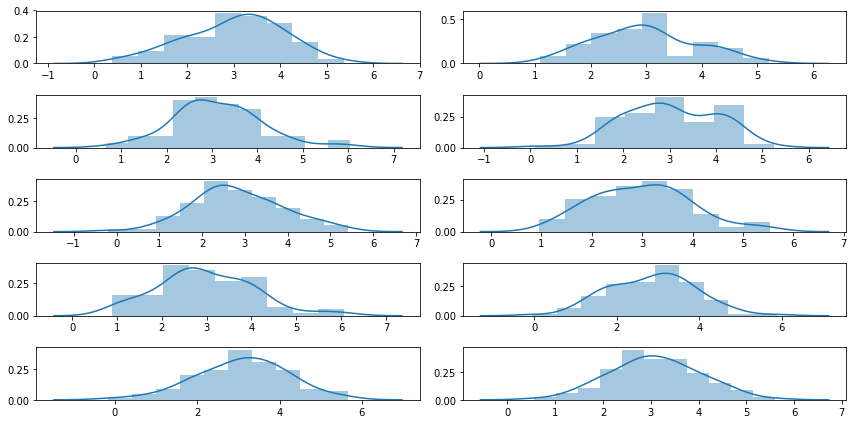

In [73]:
def normalise(x,mean,std):
    """Normalize a batch"""
    return (x-mean)/std
def get_normalised_params():
    b=get_batch(100,10000)
    mean=np.mean(b)
    std=np.std(b)
    return mean,std
    
def get_batch(N=100,batchn=10):
    a=np.random.normal(loc=3,scale=1,size=(batchn,N))
   # b=np.random.normal(loc=10,scale=0.1,size=(batchn,N))
   # ran=np.random.uniform(size=(batchn,N))
    #c=np.where(ran<0.5,a,b).astype("float32")
    #return c
    return a
mean,std=get_normalised_params()
b=get_batch()
for i in range(b.shape[0]):
    plt.subplot(5,2,i+1)
    sns.distplot(b[i,:])
plt.tight_layout()

In [74]:
import keras as ks
import tensorflow as tf
from keras.models import Sequential
from keras import layers as L
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.8)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


Now, we define a network that will take a code, and output a vector of 100 numbers. The idea here is that this has to resemble the training set without being just a copy.

In [75]:
CODE_SIZE = 4
N_NEURON=40
N_OBJECT=100
generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='gen_input'))
generator.add(L.Dense(N_NEURON, activation='selu',
                     kernel_initializer="glorot_normal"))
generator.add(L.Dense(N_NEURON, activation='selu',
                     kernel_initializer="glorot_normal"))
generator.add(L.Dense(N_NEURON, activation='selu',
                     kernel_initializer="glorot_normal"))
generator.add(L.Dense(N_NEURON, activation='selu',
                     kernel_initializer="glorot_normal"))
generator.add(L.Dense(N_NEURON, activation='selu',
                     kernel_initializer="glorot_normal"))

generator.add(L.Dense(N_OBJECT,activation="linear",name='gen_output'))

In [76]:
discriminator = Sequential()
discriminator.add(L.InputLayer([N_OBJECT],name='disc_input'))
discriminator.add(L.Dense(N_NEURON, activation='selu',
                     kernel_initializer="glorot_normal"))
discriminator.add(L.Dense(N_NEURON, activation='selu',
                     kernel_initializer="glorot_normal"))
discriminator.add(L.Dense(N_NEURON, activation='tanh',
                     kernel_initializer="glorot_normal"))

discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

In [77]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,N_OBJECT])

logp_real = discriminator(real_data)

generated_data=generator(noise)

logp_gen = discriminator(generated_data)

In [78]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)


########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:,1])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [79]:
s.run(tf.global_variables_initializer())
s.run(tf.local_variables_initializer())

In [80]:
def sample_noise_batch(bsize,CODE_SIZE):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize,N_OBJECT):
    data = get_batch(N=N_OBJECT,batchn=bsize)
    return data

def sample_objects(nrow,ncol,CODE_SIZE=CODE_SIZE,
                  N_OBJECT=N_OBJECT,norm=None):
    sampled = generator.predict(sample_noise_batch(bsize=nrow*ncol,
                                                 CODE_SIZE=CODE_SIZE))

    if not (norm is None):
        sampled=norm[1]*(sampled+norm[0])
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        sns.distplot(sampled[i])

    plt.show()

def sample_probas(bsize,N_OBJECT):
    plt.title('Generated vs real data')
    sns.distplot(np.exp(discriminator.predict(sample_data_batch(bsize,N_OBJECT)))[:,1],
             label='D(x)')
    sns.distplot(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize,CODE_SIZE))))[:,1],
             label='D(G(z))')
    plt.legend(loc='best')
    plt.show()

This is what the output from the generator looks like: at the moment it is just normal noise, centered around 0

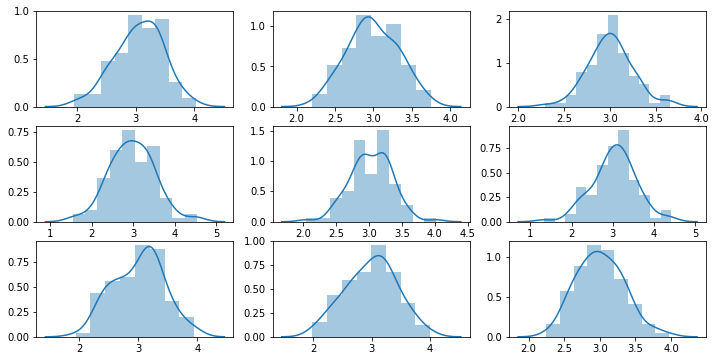

In [81]:
sample_objects(3,3,norm=(mean,std))

Then, this plot shows the probabily distributions from the discriminator. 
$D(x)$ means how the probability that the discriminator assigns to the real objects. If it were perfect, there would be a solid bar at 1 and nothing else.

$D(G(z))$ are the probabilities assigned to the objects generated by the generator: It asks "How likely is it that this thing is the real deal.

No, as we haven't trained the nets, these distributions are a bit over the place, but let's see what happens when we train them...




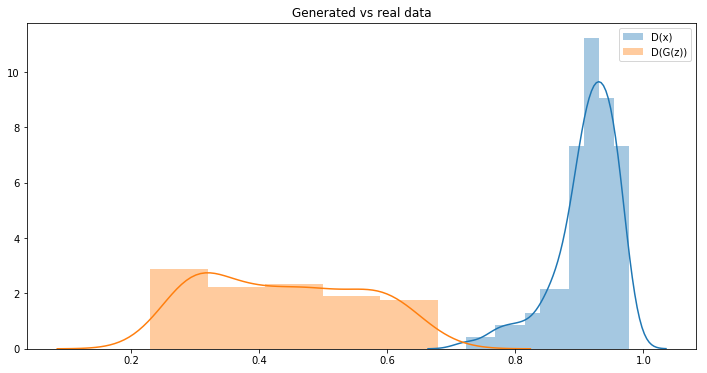

In [82]:
sample_probas(100,N_OBJECT)

In [83]:
gen_loss=[]
dis_loss=[]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jose/scratch/venv/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jose/scratch/venv/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



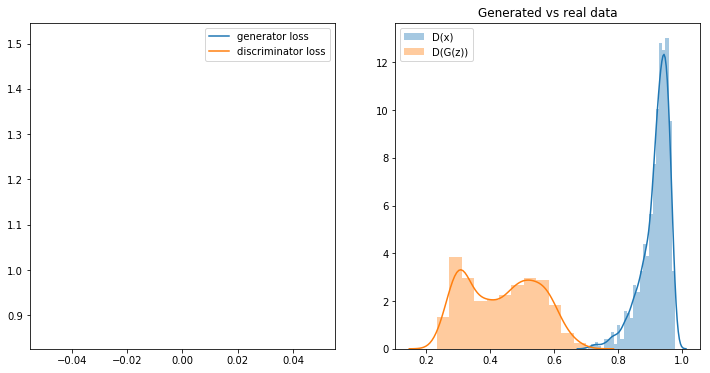

Gen loss



In [84]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(100):
    
    feed_dict = {
        real_data:normalise(sample_data_batch(1000,N_OBJECT),mean,std),
        noise:sample_noise_batch(1000,CODE_SIZE)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)

        #sample_objects(1,1,CODE_SIZE,N_OBJECT, True)
        gen_loss.append(s.run(g_loss,feed_dict))
        dis_loss.append(s.run(d_loss,feed_dict))
        plt.subplot(1,2,1)
        plt.plot(gen_loss,label="generator loss")
        plt.plot(dis_loss,label="discriminator loss")
        plt.legend()
        plt.subplot(1,2,2)
        sample_probas(1000,N_OBJECT)
        print("Gen loss")
        

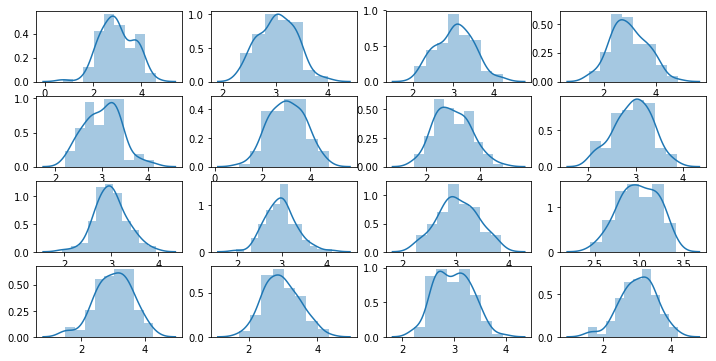

In [85]:
sample_objects(4,4,CODE_SIZE,N_OBJECT, norm=(mean,std))

# Now, with some basic images!

It has learned to produce distributions with mean 3, woo!

Now, onto something more interesting. Now, the object to be learned will be a simple image. This will be a cross located somewhere random on a 10x10 image.

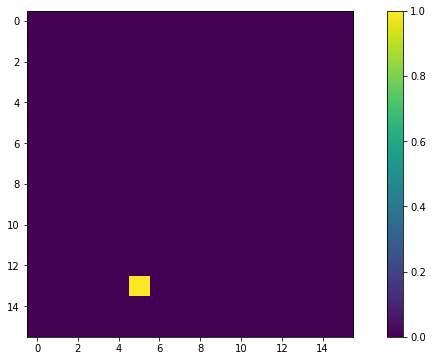

In [86]:
def get_crosses(N=5000):
    base = np.zeros((N,16,16,1))
    #Then, choose a random point
    point=np.random.randint(low=1,high=15,size=(N,2))
    x=point[:,0]
    y=point[:,1]
    base[np.arange(0,N),x,y,0]=1
    #base+=np.random.normal(loc=0,scale=0.1,size=(N,10,10,1))
    return base
crosses = get_crosses()

plt.imshow(crosses[0,:,:,0])
plt.colorbar()

In [230]:
#A vectorised convolver, powered by keras! hah
s.close()
tf.reset_default_graph()  
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
crosses_input=tf.placeholder("float32",[None,16,16,1])
cross_generator = Sequential()
cross_generator.add(L.InputLayer((16,16,1),name='cgen_input'))
cross_generator.add(L.Convolution2D(kernel_size=(4,3),filters=1,
                                    padding="same"))


kernel=np.array([[1,0,1],
                 [0,1,0],
                 [1,1,1],
                 [0,1,0]]).reshape(4,3,1,1)
bias=np.array([0])

conv_filter=cross_generator.layers[1]

conv_filter.set_weights([kernel,bias])
convolved=cross_generator(crosses_input)
conv_filter.trainable=False
cross_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cgen_input (InputLayer)      (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 1)         13        
Total params: 13
Trainable params: 0
Non-trainable params: 13
_________________________________________________________________


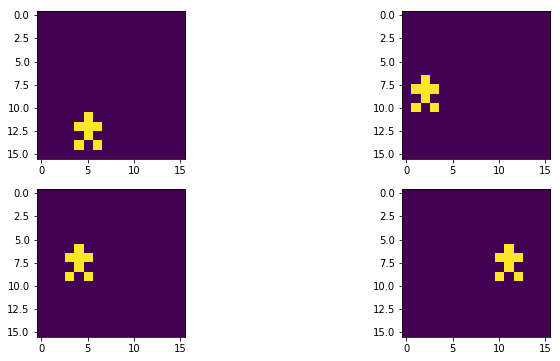

In [231]:
output=s.run(convolved,feed_dict={crosses_input:crosses})
fig, axes = plt.subplots(2,2)
for i, ax in enumerate(axes.ravel()):    
    ax.imshow(output[i,:,:,0])


In [232]:
CODE_SIZE = 10

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='gen_input'))

generator.add(L.Dense(8*8*12,kernel_initializer="glorot_normal"))

generator.add(L.LeakyReLU())


generator.add(L.Reshape((8,8,12)))
#generator.add(L.BatchNormalization(momentum=0.8))

generator.add(L.UpSampling2D())

generator.add(L.Conv2D(32,kernel_size=3,
                         kernel_initializer="glorot_normal",padding="same"))
generator.add(L.LeakyReLU())
#generator.add(L.BatchNormalization(momentum=0.8))


generator.add(L.Conv2D(64,kernel_size=3,
                         kernel_initializer="glorot_normal",padding="same"))
generator.add(L.LeakyReLU())
#generator.add(L.BatchNormalization(momentum=0.8))


generator.add(L.Conv2D(1,kernel_size=1,
                       kernel_initializer="glorot_normal",padding="same",activation="tanh"))


generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 768)               8448      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 768)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 12)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        3488      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 32)        0         
__________

In [233]:
discriminator = Sequential()
discriminator.add(L.InputLayer([16,16,1],name='disc_input'))



discriminator.add(L.Convolution2D(filters=4,kernel_size=3,
                                  kernel_initializer="glorot_normal",
                                 padding="same"))
discriminator.add(L.LeakyReLU(0.2))
#discriminator.add(L.Dropout(0.2))
#discriminator.add(L.BatchNormalization(momentum=0.8))

discriminator.add(L.MaxPool2D())


discriminator.add(L.Convolution2D(filters=8,kernel_size=3,
                                  kernel_initializer="glorot_normal",
                                 padding="same"))
discriminator.add(L.LeakyReLU(0.2))
#discriminator.add(L.Dropout(0.2))
#discriminator.add(L.BatchNormalization(momentum=0.8))

discriminator.add(L.Flatten())

discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_input (InputLayer)      (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 4)         40        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 4)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 8)           296       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
__________

In [234]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,16,16,1])

logp_real = discriminator(real_data)

generated_data=generator(noise)

logp_gen = discriminator(generated_data)

In [235]:
########################
#discriminator training#
########################
#https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/
# log(D(x))+log(1-D(G(z)))
d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
#d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)


########################
###generator training###
########################

#log(G(z))
g_loss = -tf.reduce_mean(logp_gen[:,1])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)


s.run(tf.global_variables_initializer())
s.run(tf.local_variables_initializer())
conv_filter.set_weights([kernel,bias])

In [236]:
def sample_noise_batch(bsize,CODE_SIZE):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')


def sample_data_batch(bsize):
    data = get_crosses(N=bsize)
    output=s.run(convolved,feed_dict={crosses_input:data})
    output+=np.random.normal(loc=0,scale=0.1,size=(bsize,16,16,1))
    return output

def sample_objects(nrow,ncol,CODE_SIZE=CODE_SIZE,norm=None):
    sampled = generator.predict(sample_noise_batch(bsize=nrow*ncol,
                                                 CODE_SIZE=CODE_SIZE))

    if not (norm is None):
        sampled=norm[1]*(sampled+norm[0])
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(sampled[i,:,:,0],cmap="gray")

    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    sns.distplot(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)',kde=False)
    sns.distplot(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize,CODE_SIZE))))[:,1],
             label='D(G(z))',kde=False,ax=plt.gca())
    plt.legend(loc='best')
    plt.show()

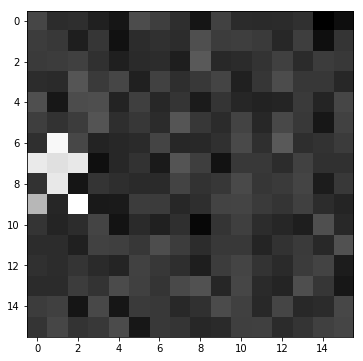

In [237]:
plt.imshow(sample_data_batch(1).reshape(16,16),cmap="gray")

In [238]:
gen_loss=[]
dis_loss=[]

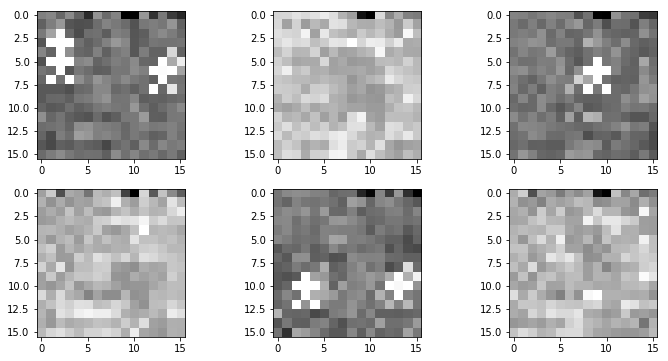

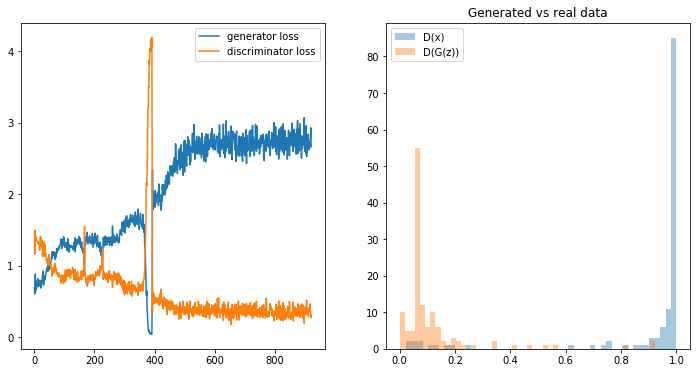

In [252]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    
    feed_dict = {
        real_data:sample_data_batch(128),
        noise:sample_noise_batch(128,CODE_SIZE)

    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_objects(2,3)
        
        gen_loss.append(s.run(g_loss,feed_dict))
        dis_loss.append(s.run(d_loss,feed_dict))
        plt.subplot(1,2,1)
        plt.plot(gen_loss,label="generator loss")
        plt.plot(dis_loss,label="discriminator loss")
        plt.legend()
        plt.subplot(1,2,2)
        sample_probas(128)
        
        